In [105]:
using Pkg
Pkg.activate("../..");
Pkg.status();
using CarbonI, vSmartMOM, SpecialPolynomials, FiniteDiff, LinearAlgebra
using DelimitedFiles, ImageFiltering, ForwardDiff, DiffResults
using CairoMakie

Read in the testbed spectra:

In [12]:
testbed_ch4 = readdlm("../../data/20250131 CITB CH4.csv",',');

In [227]:
# Load Cross section database
ch4 = vSmartMOM.load_interpolation_model(CarbonI.xs_folder*"/ch4_model.jld2")
# Generate cross section at TestBed condition
p = 940.0 # Pressure in hPa
T = 290.0 # Temperature in K
Δwl = 0.01 # Resolution in nm
wl_grid_hr = 2030:Δwl:2398
xs_ch4  = reverse(vSmartMOM.absorption_cross_section(ch4, wl_grid_hr, p, T; wavelength_flag=true)); # Has to be reversed to match the order of the data (as table is in wavenumber)


In [31]:
# Define an instrument (Convolution of 2 Box kernels with a Gaussian):

FWHM  = 2.5  # 
SSI  = 0.7
kern1 = CarbonI.box_kernel(2*SSI, Δwl)
kern2 = CarbonI.gaussian_kernel(FWHM, Δwl)
# Pixel response (1*SSI)
kern3 = CarbonI.box_kernel(SSI, Δwl)
# Combine the kernels:
kernf = imfilter(imfilter(kern1, kern2), kern3)
CarbonI_SRF = CarbonI.KernelInstrument(kernf, collect(2036.7:SSI:2394.4));

In [32]:
vcd = 0.8e20 # molec/cm²
# Transmission of entire cell:
T_CH4 = exp.(-xs_ch4*vcd)
# Transmission of instrument:
T_CH4_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T_CH4);

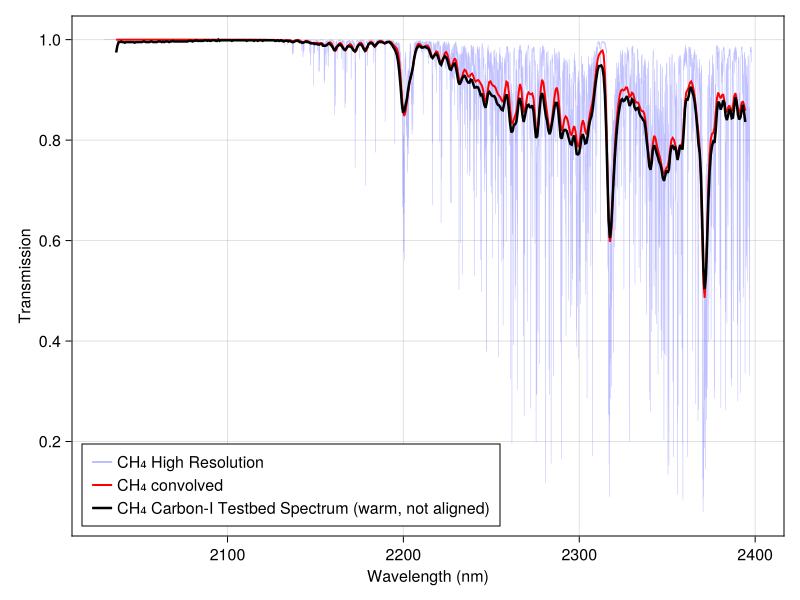

In [33]:
f = Figure(resolution = (800, 600))
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
lines!(ax, wl_grid_hr, T_CH4, color = :blue, linewidth = 0.5, alpha=0.25, label = "CH₄ High Resolution")
lines!(ax, CarbonI_SRF.ν_out, T_CH4_conv, color = :red, linewidth = 2.0, label = "CH₄ convolved")
lines!(ax, testbed_ch4[:,1], testbed_ch4[:,2]./maximum(testbed_ch4[:,2]), color = :black, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
axislegend(position = :lb)
f

In [ ]:
# Set up a simple forward model to fit the data
function forward_model_testbed(x::AbstractArray{FT} ;xs_ch4 = xs_ch4, wl_grid_hr = wl_grid_hr, Δwl=Δwl) where {FT}
    # Extract the parameters
    # Start Wavelength
    wl_start = x[1]
    # SSI
    SSI = x[2]
    # SSI change in square
    SSI_square  = x[3]
    # Fixed grid for now:
    ind = 50:500
    carbonI_wlGrid = wl_start .+ ind * SSI .+  ind.^2 * SSI_square
    
    # Vertical Column:
    vcd = x[4]
    # FWHM 
    FWHM = x[5]
    #box = x[6]
    # Poynomial term
    poly = Legendre(x[6:end])
    # Compute total optical thickness (cross section * vertical column density)
    τ = xs_ch4 * vcd
    # Compute Transmission
    T = exp.(-τ)
    #@show T
    # Define the instrument SRF:
    #SSI  = 0.7
    # Narrower slit for TestBed (simulates slit width as boxcar):
    kern1 = CarbonI.box_kernel(2SSI, Δwl)
    # Just one SSI box kernel ((simulates pixel dimension as boxcar))
    kern2 = CarbonI.gaussian_kernel(FWHM, Δwl)
    # Pixel response (1*SSI)
    kern3 = CarbonI.box_kernel(SSI, Δwl)
    # Combine the kernels:
    kernf = imfilter(imfilter(kern1, kern2), kern3)
    CarbonI_SRF = CarbonI.KernelInstrument(kernf, carbonI_wlGrid);
    # Generate final convolution matrix:
    #cM = CarbonI.generate_conv_matrix(CarbonI_SRF,wl_grid_hr, Δwl)

    #@show CarbonI_SRF

    # Convolve with instrument function
    T_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T)
    x_poly = CarbonI.rescale_x(CarbonI_SRF.ν_out)
    #@show poly.(x_poly)
   return T_conv .* poly.(x_poly)
end

forward_model_testbed (generic function with 1 method)

In [148]:
# Test a simple model

In [210]:
x = [2036.7, 0.7, 0, 0.8e20, 2.5,  1.0, 0.0e-10, 0.0e-10, 0.0e-10, 0.0e-10,0.0e-10, 0.0e-10, 0.0e-10,0.0e-10,0.0e-10, 0.0e-10,0.0e-10];
yy = forward_model_testbed(x);
wl_grid = getGrid(x)
size(y)

(451,)

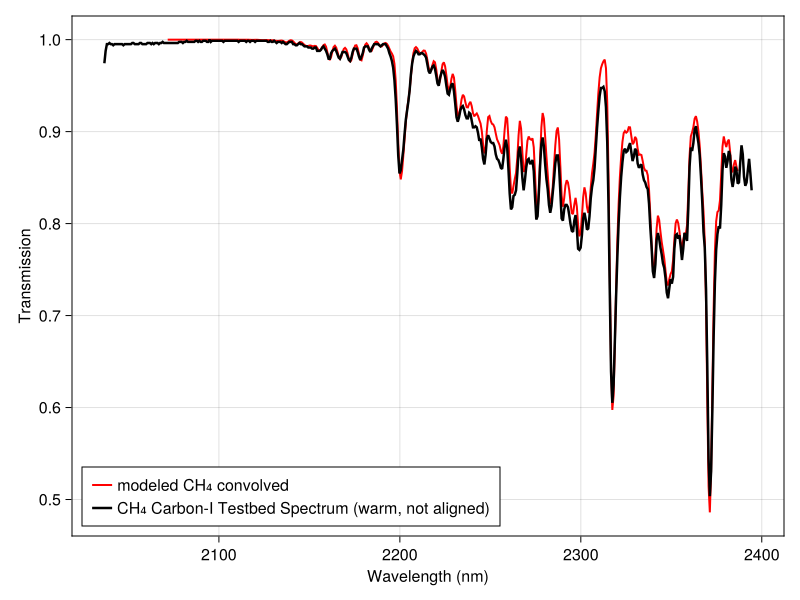

In [211]:
f = Figure(resolution = (800, 600))
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
lines!(ax, wl_grid, yy, color = :red, linewidth = 2.0, label = "modeled CH₄ convolved")
lines!(ax, testbed_ch4[:,1], testbed_ch4[:,2]./maximum(testbed_ch4[:,2]), color = :black, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
axislegend(position = :lb)
f

In [202]:
ind = 50:500
result = DiffResults.JacobianResult(zeros(length(ind)),x);

In [203]:
# Not using analytical jacobian for now as the instrument model is not differentiable at the moment (easy to do later)
K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x)
F = forward_model_testbed(x);

In [229]:
# Perform fit:
n_iter = 10
x_all = zeros(length(x),n_iter+1);
x_all[:,1] .= x;
xa = x;
y = testbed_ch4[:,2]./maximum(testbed_ch4[:,2]);
y = y[ind.+1];
Se = Diagonal((0.002*y).^2);
Sa = zeros(length(x),length(x));
Sa[1,1] = 0.03^2;
Sa[2,2] = 0.02^2;
Sa[3,3] = 0.02^2;
Sa[4,4] = 5e20^2;
Sa[5,5] = 0.5^2;
# For polynomial terms
for i=6:length(x)
    Sa[i,i] = 1^2;
end


@show "start"
for i=1:n_iter
    @show i
    K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x_all[:,i]);
    F = forward_model_testbed(x_all[:,i]);
    iGain = inv(K'inv(Se)K + inv(Sa))K'inv(Se);
    x_all[:,i+1] = xa + iGain * (y - F + K *(x_all[:,i]-xa));
end


In [216]:
function getGrid(x, ind=50:500)
    wl_start = x[1]
    # SSI
    SSI = x[2]
    # SSI change in square
    SSI_square  = x[3]
    
    carbonI_wlGrid = wl_start .+ ind * SSI .+  ind.^2 * SSI_square
    return carbonI_wlGrid
end

getGrid (generic function with 2 methods)

In [217]:
y_fit = forward_model_testbed(x_all[:,end]);

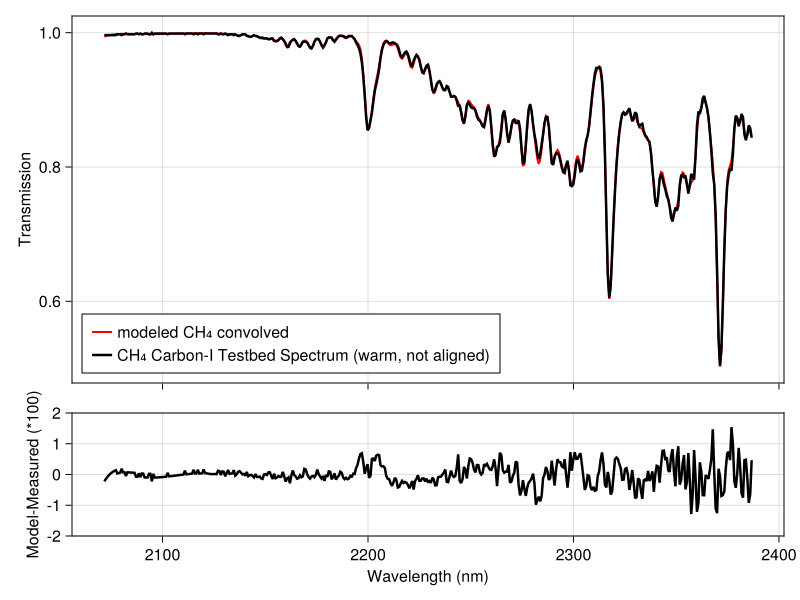

In [233]:
f = Figure(resolution = (800, 600))
ii = ind .+1 
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
ax2 = Axis(f[2, 1], xlabel = "Wavelength (nm)", ylabel = "Model-Measured (*100)")
lines!(ax,  getGrid(x_all[:,1], ind), y_fit, color = :red, linewidth = 2.0, label = "modeled CH₄ convolved")
#lines!(ax, CarbonI_SRF.ν_out, forward_model_testbed(x), color = :green, linewidth = 2.0, label = "prior CH₄ convolved")
lines!(ax, testbed_ch4[ii,1], y, color = :black, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
axislegend(ax,position = :lb)
lines!(ax2, getGrid(x_all[:,1], ind), (y_fit.-y)*100, color = :black, linewidth = 2.5, label = "Fit Residual")
ylims!(ax2, (-2,2))
rowsize!(f.layout, 2, Relative(0.25))
ax.xticklabelsvisible = false
ax.xlabelvisible = false
f

In [231]:
x_all

17×11 Matrix{Float64}:
 2036.7     2036.68         2036.69         …  2036.69         2036.69
    0.7        0.703073        0.703481           0.703479        0.703479
    0.0       -7.12685e-6     -8.11779e-6        -8.11774e-6     -8.11774e-6
    8.0e19     7.6659e19       7.72135e19         7.72821e19      7.72821e19
    2.5        2.7189          2.73683            2.74014         2.74014
    1.0        0.985856        0.986471     …     0.986536        0.986536
    0.0       -0.0178076      -0.0169244         -0.0168277      -0.0168277
    0.0        0.00182356      0.00193945         0.00195187      0.00195187
    0.0        0.0132146       0.0129032          0.0128694       0.0128694
    0.0        0.000533843     0.000520159        0.000503956     0.000503955
    0.0       -0.00898677     -0.00889969   …    -0.0089012      -0.0089012
    0.0       -0.00382474     -0.00379606        -0.00380674     -0.00380674
    0.0        0.0051554       0.00502033         0.00500181      0.